# Homework 3 - Option 1 - Simulation

In this homework assignment I will use SimPy to do discrete event simulation.

The scenario I have chosen is that of a border crossing where cars can must first stop at a booth to speak to a border control officer (primary inspection). 

Some percentage of cars will be asked to pull aside for a random (or not so random) secondary inspection. 

In our scenario all cars eventually make it through customs and move along on their merry way.

Let's have some fun with SimPy!...

## Preliminaries

In [5]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import libraries likely needed for the task

In [6]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy


## Using discrete event simulation to model traffic at a border crossing

Ultimately, our goal in this module is to develop a DES model of a simple border crossing scenario consisting of the following process steps:

```
Arrival --> Primary Inspection --> Documentation Scan--> Declaration of Goods (if needed) --> Secondary Inspection (if needed) -->  Exit
```

Conceptually, our model has the following components:

* The entities are vehicles.
* Entities are created by some sort of arrival process.
* Each stage of the process has some number of resources associated with it. These resources are the border control officers that man the Inspection stations.
* Entities flow through different stages of the border crossing process, and at each stage, they:
    - request one unit of the appropriate type of officer resource and wait if one is not available,
    - after obtaining an officer resource they delay for some amount of time for the process (e.g. questioning, scanning documentation, declaring purchases) to be completed,
    - when the processing time has elapsed, the resource is released and the vehicle may move on to a Secondary Inspection
* When all stages are complete, the vehicle exits the system.

Our model should handle:

* uncertainty in the processing times of the individual steps above,
* uncertainty in vehicle arrival times
* finite numbers of different types of resources (officers)
* ability to estimate key process metrics such as vehicle wait times and total time at the border crossing as well as resource utilization.

# The Model

## Model 1 - Vehicle arrival generator only

We will start with a simple model that generates vehicle arrivals on a regular basis, then the vehicles  -->  Exit Border Crossing

In [7]:
def vehicle_arrivals(env, interarrival_time=2.0):
    """Generate vehicles according to a fixed time arrival process"""

    # Create a counter to keep track of number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Infinite loop for generating vehicles
    while True:

        # Generate next interarrival time (simple for now - this will be revised later)
        iat = interarrival_time
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New vehicle generated = update counter of vehicles
        vehicle += 1
        
        print(f"Vehicle {vehicle} created at time {env.now}")

In [8]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the vehicle_arrivals process and adds it to the environment
runtime = 25
interarrival_time = 2.0
env1.process(vehicle_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Vehicle 1 created at time 2.0
Vehicle 2 created at time 4.0
Vehicle 3 created at time 6.0
Vehicle 4 created at time 8.0
Vehicle 5 created at time 10.0
Vehicle 6 created at time 12.0
Vehicle 7 created at time 14.0
Vehicle 8 created at time 16.0
Vehicle 9 created at time 18.0
Vehicle 10 created at time 20.0
Vehicle 11 created at time 22.0
Vehicle 12 created at time 24.0


As cars arriving on a regular schedule is very unrealistic, we will start to improve our model by modeling vehicle arrivals by a *Poisson arrival process*

First we need to import the default random number generator and create a random generator variable. I'll use 2616 as the seed. This generator generates numbers uniformly between 0 and 1, which can be used to generate random variates from whatever distribution we choose. 

In [10]:
from numpy.random import default_rng
rg = default_rng(seed=2616)
print(rg.random())

0.13682387149554032


Now we'll use our random number generator to overlay the exponential pdf (probability density function) on our histogram of generated exponential random variates.

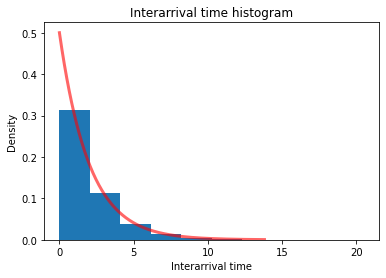

In [13]:
# Import exponential distribution function from scipy.stats
from scipy.stats import expon

# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time

# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)



# Generate 1000 exponential random variates (Exponential function from numpy)
iat_sample = rg.exponential(mean_interarrival_time, 10000)

# Create a histogram of the random samples with exponential pdf overlaid
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

# Create values for the x-axis using expon function from SciPy
x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

# Create values for the y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf,
       'r-', lw=3, alpha=0.6, label='Exponential pdf');

Now, we can modify our vehicle arrivals function to use Poisson arrivals instead of equally-spaced deterministic arrivals.

In [14]:
def vehicle_arrivals_random_1(env, mean_interarrival_time=2.0, rg=default_rng(0)):
    """Generate vehicles according to a Poisson arrival process"""

    # Create a counter to keep track of the number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Infinite loop for generating vehicles
    while True:

        # Generate next interarrival time from exponential distribution
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of vehicles
        vehicle += 1
        
        print(f"Vehicle {vehicle} created at time {env.now}")

Now we can run this new model with random arrivals...

In [17]:
# Initialize a new simulation environment
env2 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env
runtime = 25
interarrival_time = 2.0
env2.process(vehicle_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Vehicle 1 created at time 2.4643412877955218
Vehicle 2 created at time 8.320679914421646
Vehicle 3 created at time 8.628057431597927
Vehicle 4 created at time 11.559667261969569
Vehicle 5 created at time 13.808142320108066
Vehicle 6 created at time 17.604243156767176
Vehicle 7 created at time 18.802227105059586
Vehicle 8 created at time 19.73959643369937
Vehicle 9 created at time 21.373811066654508
Vehicle 10 created at time 21.90274962336238
Vehicle 11 created at time 23.394394601372817
Vehicle 12 created at time 23.606518713330075


## Model 2: Simplified border crossing with one resource